# Deskewing on CPU and GPU

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle
import numpy as np

In [2]:
#Read lattice file
rbc = imread("../sample_data/RBC_lattice.tif")

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

print("Shape of original image", rbc.shape )

Shape of original image (150, 118, 209)


In [3]:
#Perform deskewing on rbc image  
deskewed = cle.deskew_y(rbc, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

print("Shape of deskewed image",deskewed.shape)

Shape of deskewed image (59, 416, 209)


In [4]:
def deskew_y_cpu(input_image,
             output_image = None,
             angle_in_degrees: float = 30,
             voxel_size_x: float = 1,
             voxel_size_y: float = 1,
             voxel_size_z: float = 1,
             scaling_factor: float = 1):

    # Set up a deskew transform
    transform = cle.AffineTransform3D()
    transform._deskew_y(angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)
    
    # modify transform so that all pixels are in the positive 
    # coorindate system and within the image
    new_size, autosize_transform, translation = cle._tier8._affine_transform._determine_translation_and_bounding_box(
                                    rbc, transform)
    
    # We need to exchange X and Z in the transform matrix, 
    # to make scipy understand the transform defined by cle
    autosize_transform._pre_concatenate(np.asarray([
        [0,0,1,0],
        [0,1,0,0],
        [1,0,0,0],
        [0,0,0,1],
    ]))

    if output_image is None:
        output_image = np.zeros(new_size[::-1])
        
    from scipy.ndimage import affine_transform
    
    result = affine_transform(input_image, autosize_transform.inverse()._matrix, output=output_image)
    
    # cle and scipy have different understanding of X and Z.
    # Hence, we need to transpose the result
    return np.transpose(result, (2, 1, 0))


In [5]:
#Perform deskewing on rbc image using CPU
deskewed_cpu = deskew_y_cpu(rbc, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

print("Shape of deskewed image",deskewed_cpu.shape)

Shape of deskewed image (59, 416, 209)


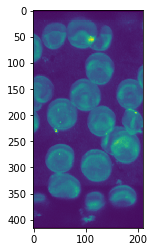

In [6]:
cle.imshow(deskewed_cpu)

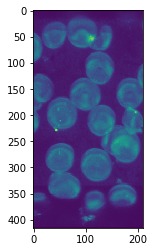

In [7]:
cle.imshow(deskewed)